In [76]:
##Mount Google Drive to Colab VM

#from google.colab import drive
#drive.mount('/content/drive')

##Navigate to root working folder
#%cd /content/drive/My Drive/Springboard/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Springboard


In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.naive_bayes import CategoricalNB

In [78]:
#Import data from previous step

df = pd.read_csv('SecondCapstone/data/data_clean.csv')
X = df.drop(columns=['h1n1_vaccine', 'seasonal_vaccine'])  #Separating features and Labels
y = df[['h1n1_vaccine', 'seasonal_vaccine']]

In [ ]:
#Doing Train Test Split of Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [79]:
#renaming columns to avoid issues with XGBoost later on, XGBoost can't have '<' or ',' in the feature names
X_train.rename(columns={'education_< 12 Years':'education_less_than_12y','income_poverty_<= $75,000, Above Poverty':'income_poverty_less_than_or_equal_75000_above_poverty','income_poverty_> $75,000':'income_poverty_greater_than_75000' }, inplace=True)
X_test.rename(columns={'education_< 12 Years':'education_less_than_12y','income_poverty_<= $75,000, Above Poverty':'income_poverty_less_than_or_equal_75000_above_poverty','income_poverty_> $75,000':'income_poverty_greater_than_75000' }, inplace=True)

In [80]:
# Creating function for confusion matrix as it will be used for every model
# Code taken from https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

def conf_mat(ytest, ypred):
    pl = metrics.confusion_matrix(ytest,ypred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in pl.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in pl.flatten()/np.sum(pl)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    return sns.heatmap(pl, annot=labels, fmt='', cmap='Blues')

My problem requires a supervised classification model.  I will model and examine the metrics for Ensemble Random Forest, Naive Bayes & XGBoost.

### **Random Forest**

In [81]:
#Performing Gridsearch for Hyperparameter Tuning
#Grid Search for H1n1 Results

clf_h1n1 = RandomForestClassifier()
clf_seasonal = RandomForestClassifier()

param_grid = {'n_estimators' : range(100, 200, 10)}

clf_cv = GridSearchCV(clf_h1n1, param_grid, cv=3)
clf_cv.fit(X, y['h1n1_vaccine'])

print("H1N1 Vaccine")
print("Tuned Parameters: {}".format(clf_cv.best_params_)) 
print("Best score is {}".format(clf_cv.best_score_))
h1n1_n_estimators = clf_cv.best_params_['n_estimators']

H1N1 Vaccine
Tuned Parameters: {'n_estimators': 140}
Best score is 0.8246031946657318


In [83]:
#Grid Search for Seasonal Results

clf_cv = GridSearchCV(clf_seasonal, param_grid, cv=3)
clf_cv.fit(X, y['seasonal_vaccine'])

print("Seasonal Vaccine")
print("Tuned Parameters: {}".format(clf_cv.best_params_)) 
print("Best score is {}".format(clf_cv.best_score_))
seasonal_n_estimators = clf_cv.best_params_['n_estimators']

Seasonal Vaccine
Tuned Parameters: {'n_estimators': 160}
Best score is 0.7733534113535852


In [84]:
#Random Forest Prediction using tuned parameter results

clf_h1n1 = RandomForestClassifier(n_estimators=h1n1_n_estimators)
clf_seasonal = RandomForestClassifier(n_estimators=seasonal_n_estimators)

clf_h1n1.fit(X_train, y_train['h1n1_vaccine'])
clf_seasonal.fit(X_train, y_train['seasonal_vaccine'])

y_pred_h1n1 = clf_h1n1.predict(X_test)
y_pred_seasonal = clf_seasonal.predict(X_test)

In [85]:
#Classification Report of model results for Training Data
print('H1N1 Vaccine - Random Forest Classifier')
print(metrics.classification_report(y_test['h1n1_vaccine'], y_pred_h1n1))
print('Seasonal Vaccine - Random Forest Classifier')
print(metrics.classification_report(y_test['seasonal_vaccine'], y_pred_seasonal))

H1N1 Vaccine - Random Forest Classifier
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      3868
           1       0.73      0.33      0.45      1085

    accuracy                           0.83      4953
   macro avg       0.78      0.65      0.68      4953
weighted avg       0.81      0.83      0.80      4953

Seasonal Vaccine - Random Forest Classifier
              precision    recall  f1-score   support

           0       0.77      0.80      0.79      2617
           1       0.77      0.74      0.75      2336

    accuracy                           0.77      4953
   macro avg       0.77      0.77      0.77      4953
weighted avg       0.77      0.77      0.77      4953



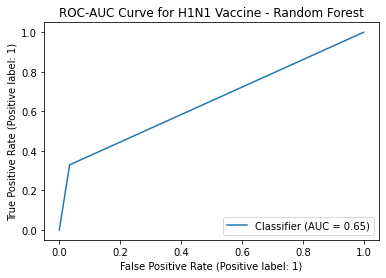

In [86]:
#ROC Curve
metrics.RocCurveDisplay.from_predictions(y_test['h1n1_vaccine'], y_pred_h1n1)
plt.title('ROC-AUC Curve for H1N1 Vaccine - Random Forest')
plt.show()

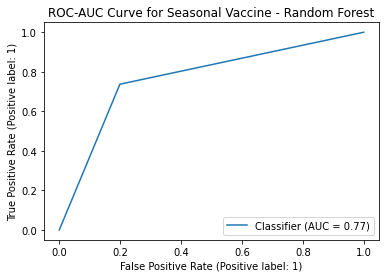

In [87]:
metrics.RocCurveDisplay.from_predictions(y_test['seasonal_vaccine'], y_pred_seasonal)
plt.title('ROC-AUC Curve for Seasonal Vaccine - Random Forest')
plt.show()

In [88]:
#Storing feature scores for each label for further use and graphing
feature_score_h1n1 = pd.Series(clf_h1n1.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_score_seasonal = pd.Series(clf_seasonal.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_names = X_train.columns

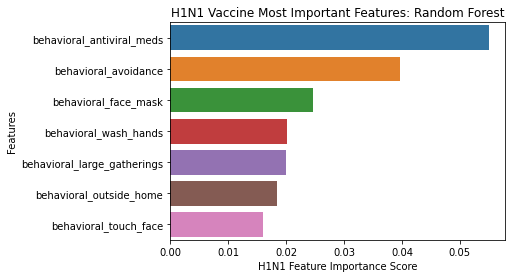

In [89]:
#Barplot of Feature Importance, most important features, H1N1 vaccine
sns.barplot(x=feature_score_h1n1[0:7], y=feature_names[0:7]) #graphing top 7 most important features
plt.title('H1N1 Vaccine Most Important Features: Random Forest')
plt.xlabel('H1N1 Feature Importance Score')
plt.ylabel('Features')
plt.show()

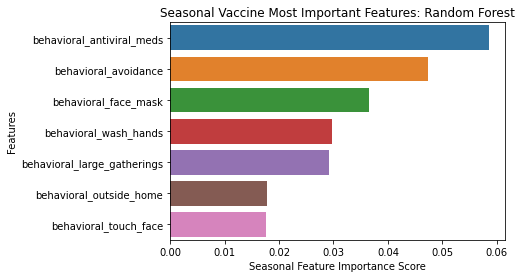

In [90]:
#Barplot of Feature Importance, most important features, seasonal vaccine
sns.barplot(x=feature_score_seasonal[0:7], y=feature_names[0:7]) #graphing top 7 most important features
plt.xlabel('Seasonal Feature Importance Score')
plt.ylabel('Features')
plt.title('Seasonal Vaccine Most Important Features: Random Forest')
plt.show()

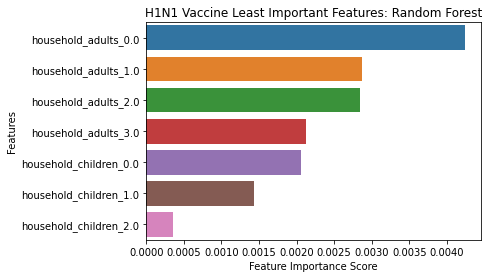

In [91]:
#Barplot of Feature Importance, least important features, H1N1 vaccine
sns.barplot(x=feature_score_h1n1[-8:-1], y=feature_names[-8:-1]) #graphing 7 least important features
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("H1N1 Vaccine Least Important Features: Random Forest")
plt.show()

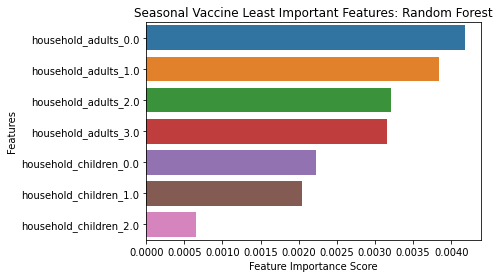

In [92]:
#Barplot of Feature Importance, least important features, seasonal vaccine
sns.barplot(x=feature_score_seasonal[-8:-1], y=feature_names[-8:-1]) #graphing 7 least important features
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Seasonal Vaccine Least Important Features: Random Forest')
plt.show()

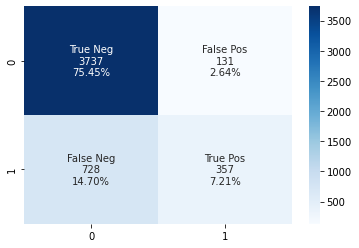

In [93]:
conf_mat(y_test['h1n1_vaccine'], y_pred_h1n1)  #Confusion Matrix for H1N1 results
plt.show()

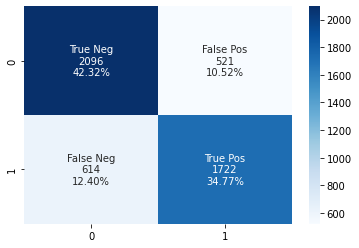

In [94]:
conf_mat(y_test['seasonal_vaccine'], y_pred_seasonal) #Confusion Matrix for Seasonal results
plt.show()

## **Naive Bayes**

In [95]:
cnb_h1n1 = CategoricalNB()
cnb_seasonal = CategoricalNB()

cnb_h1n1.fit(X_train, y_train['h1n1_vaccine'])
cnb_seasonal.fit(X_train, y_train['seasonal_vaccine'])

y_pred_h1n1 = cnb_h1n1.predict(X_test)
y_pred_seasonal = cnb_seasonal.predict(X_test)

In [96]:
print('H1N1 Vaccine - Naive Bayes Classifier')
print(metrics.classification_report(y_test['h1n1_vaccine'], y_pred_h1n1))
print('Seasonal Vaccine - Naive Bayes Classifier')
print(metrics.classification_report(y_test['seasonal_vaccine'], y_pred_seasonal))

H1N1 Vaccine - Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      3868
           1       0.51      0.62      0.56      1085

    accuracy                           0.78      4953
   macro avg       0.70      0.73      0.71      4953
weighted avg       0.80      0.78      0.79      4953

Seasonal Vaccine - Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.76      0.77      0.76      2617
           1       0.74      0.73      0.73      2336

    accuracy                           0.75      4953
   macro avg       0.75      0.75      0.75      4953
weighted avg       0.75      0.75      0.75      4953



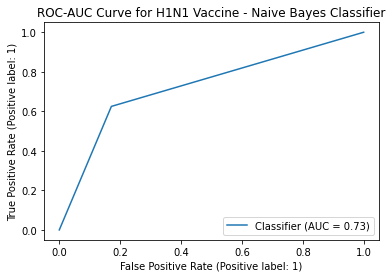

In [97]:
metrics.RocCurveDisplay.from_predictions(y_test['h1n1_vaccine'], y_pred_h1n1)
plt.title('ROC-AUC Curve for H1N1 Vaccine - Naive Bayes Classifier')
plt.show()

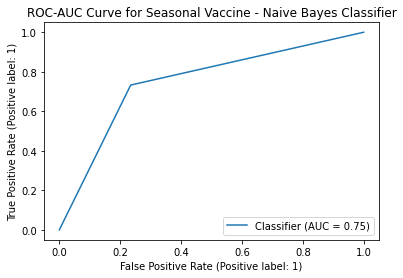

In [98]:
metrics.RocCurveDisplay.from_predictions(y_test['seasonal_vaccine'], y_pred_seasonal)
plt.title('ROC-AUC Curve for Seasonal Vaccine - Naive Bayes Classifier')
plt.show()

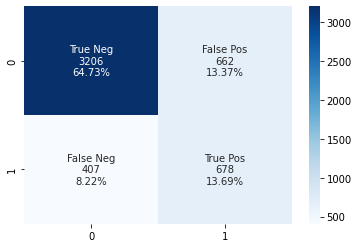

In [99]:
conf_mat(y_test['h1n1_vaccine'], y_pred_h1n1)  #Confusion Matrix for H1N1 results
plt.show()

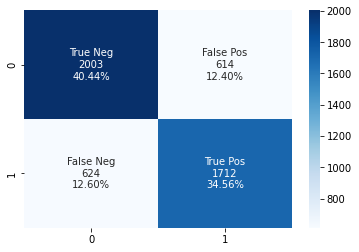

In [100]:
conf_mat(y_test['seasonal_vaccine'], y_pred_seasonal) #Confusion Matrix for Seasonal results
plt.show()

## **XGBoost**

In [101]:
xgb_h1n1 = xgb.XGBClassifier()
xgb_seasonal = xgb.XGBClassifier()

xgb_h1n1.fit(X_train, y_train.h1n1_vaccine)
xgb_seasonal.fit(X_train, y_train.seasonal_vaccine)

y_pred_h1n1 = xgb_h1n1.predict(X_test)
y_pred_seasonal = xgb_seasonal.predict(X_test)

In [102]:
print('H1N1 Vaccine - XGBoost Classifier')
print(metrics.classification_report(y_test['h1n1_vaccine'], y_pred_h1n1))
print('Seasonal Vaccine - XGBoost Classifier')
print(metrics.classification_report(y_test['seasonal_vaccine'], y_pred_seasonal))

H1N1 Vaccine - XGBoost Classifier
              precision    recall  f1-score   support

           0       0.84      0.96      0.90      3868
           1       0.72      0.36      0.48      1085

    accuracy                           0.83      4953
   macro avg       0.78      0.66      0.69      4953
weighted avg       0.82      0.83      0.81      4953

Seasonal Vaccine - XGBoost Classifier
              precision    recall  f1-score   support

           0       0.79      0.81      0.80      2617
           1       0.78      0.76      0.77      2336

    accuracy                           0.78      4953
   macro avg       0.78      0.78      0.78      4953
weighted avg       0.78      0.78      0.78      4953



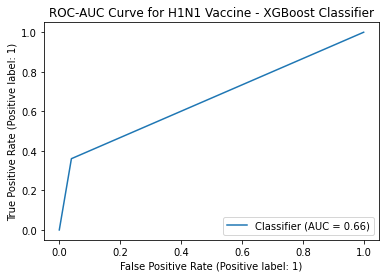

In [103]:
metrics.RocCurveDisplay.from_predictions(y_test['h1n1_vaccine'], y_pred_h1n1)
plt.title('ROC-AUC Curve for H1N1 Vaccine - XGBoost Classifier')
plt.show()

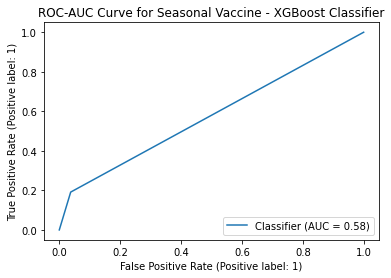

In [104]:
metrics.RocCurveDisplay.from_predictions(y_test['seasonal_vaccine'], y_pred_h1n1)
plt.title('ROC-AUC Curve for Seasonal Vaccine - XGBoost Classifier')
plt.show()

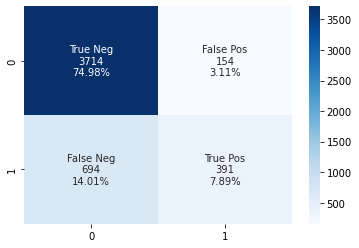

In [105]:
conf_mat(y_test['h1n1_vaccine'], y_pred_h1n1)  #Confusion Matrix for H1N1 results
plt.show()

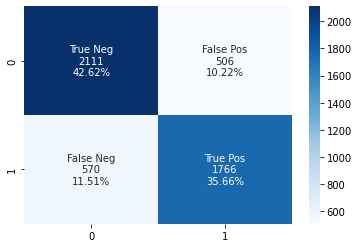

In [106]:
conf_mat(y_test['seasonal_vaccine'], y_pred_seasonal) #Confusion Matrix for Seasonal results
plt.show()

Based on the Resulting ROC_AUC Scores Naive Bayes is the best predictive model